# Training Analysis - Reinforcement Learning
We will try some basic reinforcement learning (RL) models like the temporal difference based Rescorla-Wagner model, and the "attentional" model developed by Pearce and Hall. First, we plot real data, from both probablistic serial reversal (PSR) and deterministic serial reversal tasks (DSR). How did animals "learn to relearn" across training. Then, we will simulate entire datasets, by using "Rat" and "SessionSimulator" objects with different parameters of the RL models. Then we will plot how those agents learned over time and see if it resembled what real rats did. 

In [213]:
import os
import pickle
import time
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy import signal as sig
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
idx = pd.IndexSlice
ROOT = os.environ['HOME'] + '/python/'


In [49]:
def get_block_performances(TRAINING_DSR, block = 1):
    B1 = {}
    for animal_label, animal_data in TRAINING_DSR.groupby(level = 'rat'):
        tmp = []
        for session_label, session \
                in animal_data.loc[idx[:,:,block,:],:].groupby(level = 'training_session'):
            tmp.append(np.float(np.sum(session['Correct'])) / len(session))
        B1[animal_label] = tmp
    return B1

#converts input array to smooth array of length standard_length
def standarize(ar, standard_length = 10, window_size = 3):
    f = interp1d(np.linspace(0, standard_length, len(ar)), ar)
    return sig.savgol_filter(f(range(standard_length)), window_size, 2)


In [226]:
#load data
TRAINING_DSR = pickle.load(open('DATA_structures/session_dataframes/DSR_TRAINING_SESSIONS_DATAFRAME.p', 'rb'))
TRAINING_PSR = pickle.load(open('DATA_structures/session_dataframes/PSR_TRAINING_SESSIONS_DATAFRAME.p', 'rb'))
#obtain accuracy per block
DSR_B1 = get_block_performances(TRAINING_DSR, block = 1)
DSR_Rev1 = get_block_performances(TRAINING_DSR, block = 2)
PSR_B1 = get_block_performances(TRAINING_PSR, block = 1)
PSR_Rev1 = get_block_performances(TRAINING_PSR, block = 2)


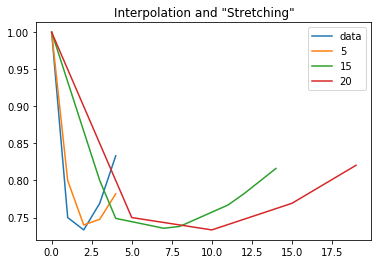

In [51]:
#let's try out our standarize function
sample_data = DSR_B1['21']
plt.plot(sample_data)

for standard_length in [5,15,20]:
    plt.plot(standarize(sample_data, standard_length = standard_length))
plt.legend(['data','5','15','20'])
plt.title('Interpolation and "Stretching"')
plt.show()

## Block 1 and Rev 1 Performance Across Training
We will now either interpolate or strech all the accuracy scores across sessions for all the animals and put them in one plot. We will plot is as the mean with colorbars arround it representing the SEM. 

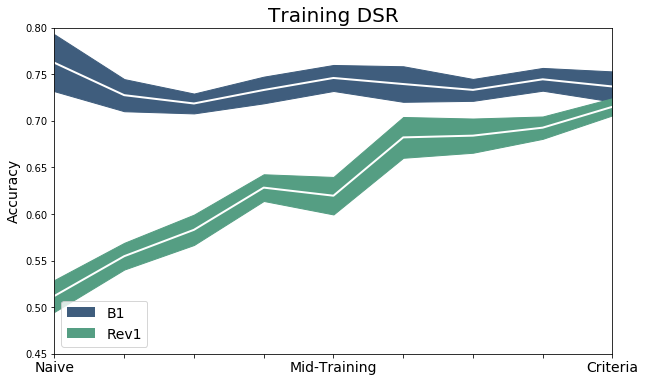

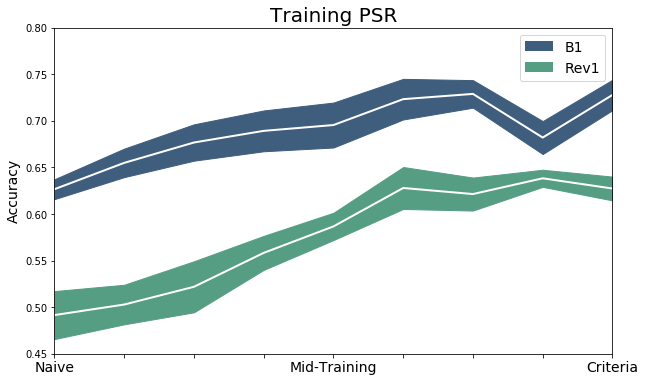

In [136]:
def curve_transform(B1, standard_length = 10):
    scores = np.zeros((len(B1), standard_length))
    for index, (key, val) in enumerate(B1.iteritems()):
        scores[index, :] = standarize(B1[key], standard_length = standard_length)
    return scores

#array must be subjects x datapoints
def prepare_line(array):
    avg = np.nanmean(array, axis = 0)
    sem = (np.nanstd(array, axis = 0) / np.sqrt(len(array)))
    return avg, sem

def fancy_line(avg, sem, ax, colorOne):
    ax.fill_between(range(len(avg)), avg - sem, avg + sem, color = colorOne)
    ax.plot(range(len(avg)), avg, color = "white", lw=2)
    

def training_plot(lines, title, ylim = [0.45, 0.8], savefig = 0):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_xlim([0,8])
    ax.set_ylim(ylim)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(range(9))
    ax.set_xticklabels(['Naive','','','','Mid-Training','','','','Criteria'],
                        fontsize = 14)

    colors = ["#3F5D7D", "#559e83", "#7d3f5d", "#5d7d3f", "#ae5a41" ]
    P = []  
    for index, line in enumerate(lines):
        array = curve_transform(line, standard_length = 9)
        avg, sem = prepare_line(array)
        fancy_line(avg, sem, ax, colors[index])
        P.append(Rectangle((0, 0), 1, 1, fc = colors[index]))


    plt.legend(P, ['B1', 'Rev1'], fontsize=14, loc = 'best')
    plt.title(title, fontsize = 20)
    if savefig: plt.savefig(title.replace(' ','_') + '.jpg', bbox_inches = 'tight', dpi= 600)
    plt.show()


training_plot([DSR_B1, DSR_Rev1], 'Training DSR', savefig = 1)
training_plot([PSR_B1, PSR_Rev1], 'Training PSR', savefig = 1)

## Rescorla-Wagner Model (1972)
R-W model is based on a temporal-difference model where the prediction error is calculated as the difference between the actual outcome with a hidden "internal" value. The magnitude difference, multiplied by some training rate alpha, gives the update to the internal value. We will explore whether increasing the learning rate can give us a learning set.  

We define two classes: Rat and Session. A rat can run many sessions and does have an internal "memory". However, we do not expect it to get much better at the task, that is part of what we are trying to prove with this analysis. But we will see obviously. A session must be insantiated every time it runs and takes as input a rat. We will create a DSR and PSR dataset based on the number of sessions and trials of the original

In [220]:
class Rat(object):
    def __init__(self,
                 ratID,
                 alpha = 0.03,
                 beta = 0.3,
                 gamma = 1):
        
        self.ID = ratID
        #initialize Q value states randomly
        self.Q = [(w - 0.5) / 5 for w in np.random.random(2)]
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def softmax(self, array, temp = 0.5):
        tmp = [np.exp(val/temp) for val in array] 
        return tmp / np.sum(tmp)
    
    def make_decision(self):
        p = self.softmax(self.Q, temp = self.beta)
        return np.digitize(np.random.random(), np.cumsum(p))

    def update_beliefs(self, reward, choice):
        self.Q[choice] += self.alpha * (reward - self.Q[choice])
        self.Q = [min(20, w) for w in self.Q] #high-filter
        self.Q = [max(-20, w) for w in self.Q] #low-filter
        

    def rest_of_day(self):
        self.Q = [w * 0.2 for w in self.Q]

        
    def update_learning_rate(self, info):
        volatility = []
        for goal in ['Q_E','Q_W']:
            smooth_signal = sig.savgol_filter(info[goal], 11, 2)
            local_max = argrelextrema(smooth_signal, np.greater)
            local_min = argrelextrema(smooth_signal, np.less)
            inflections = \
                np.concatenate([[0], local_max[0],local_min[0], [len(smooth_signal) - 1]])
            inflections.sort()
            magnitude_change = np.diff([smooth_signal[w] for w in inflections])
            avg_diff = np.nanmean([abs(w) for w in magnitude_change if abs(w) > 0.01])
            volatility.append(avg_diff)
        self.alpha += (np.mean(volatility)/5)

In [168]:

class SessionSimulator(object):
    def __init__(self,
                 Rat,
                 sessionID,
                 task = 'DSR',
                 noTrials = 120):
        
        if task == 'DSR':
            self.p = 1
        elif task == 'PSR':
            self.p = 0.85
        self.task = task
        self.noTrials = noTrials
        self.info = pd.DataFrame(np.zeros((self.noTrials, 6)),
                                 columns = ['GA','Choice','Correct','AR','Q_W','Q_E'])
        self.Rat = Rat
        self.sessionID = sessionID
        
    def run_session(self):
        #block
        block = [0] * 12
        #randomly select the initial goal
        GA = int(np.random.random() > 0.5)
        
        for trial in range(self.noTrials):
            #record current goal arm
            self.info['GA'].iat[trial] = GA

            #trial starts with rat making a choice
            choice = self.Rat.make_decision()
            
            #saving that choice
            self.info['Choice'].iat[trial] = choice

            #see if that's the correct choice
            correct = int(choice == GA)
            #save that information
            self.info['Correct'].iat[trial] = correct

            #determine whether you actually get a reward
            if correct == 1:
                reward = int(np.random.random() <= self.p)
            elif correct == 0:
                reward = int(np.random.random() <= (1 - self.p))
            #save that information
            self.info['AR'].iat[trial] = reward
            self.info['Q_W'].iat[trial] = rat.Q[0]
            self.info['Q_E'].iat[trial] = rat.Q[1]

            #update your belief about the environment
            self.Rat.update_beliefs(reward, choice)



            #see if a reversal has been accomplished
            #update block
            block[0:-1] = block[1:]
            block[-1] = correct
            #check if criteria happened
            if np.sum(block) >= 10:
                #reset counter
                block = [0] * 12
                #reversal
                GA = (GA + 1) % 2
        rev_points = np.nonzero(self.info['GA'].diff())[0]
        rev_points = [w for w in rev_points] + [self.noTrials]
        rev_points = np.diff(rev_points)
        mtuples = [(self.Rat.ID, self.sessionID, i + 1, v) \
                       for i,w in enumerate(rev_points) for v in range(w)]
        index = pd.MultiIndex.from_tuples(mtuples, names=['rat','training_session','block','trials'])
        self.info.index = index

## Creating the DSR Training Dataset
Ok, so we will insantiate the same number of rats as in the original experiment. They will be named the same, and run the same number of sessions and the same number of trials. 

In [229]:
def generate_dataset(TRAINING_DF, task = 'DSR', alpha = 0.03, beta = 0.1):

    rats = [label for label, data in TRAINING_DF.groupby('rat')]
    no_sessions = [len(data.groupby('training_session')) for _, data in TRAINING_DF.groupby('rat')]

    A_TRAINING_DF = []
    start = time.time()
    for ratID, no_sess in zip(rats, no_sessions):
        #instantiate rat
        rat = Rat(ratID = ratID, alpha = alpha, beta = beta)
        trials_per_session = \
            [len(sess) for label, sess in TRAINING_DF.loc[ratID].groupby('training_session')]
        for training_session_no, noTrials in zip(range(1, 1 + no_sess), trials_per_session):
            #insantiate session
            artificial_session = SessionSimulator(rat, training_session_no, task=task, noTrials = noTrials)
            #run session
            artificial_session.run_session()
            #simulate rat "resting" 
            rat.rest_of_day()
            #simulate rat updating learning rate after session is over
            #rat.update_learning_rate(artificial_session.info)
            #append information
            A_TRAINING_DF.append(artificial_session.info)
    A_TRAINING_DF = pd.concat(A_TRAINING_DF, axis = 0)
    A_TRAINING_DF.sort_index(axis = 0, inplace = True)

    print 'dataset completed in %1.2f seconds' %(time.time() - start)
    return A_TRAINING_DF

### Calculating Accuracy and Plotting
Since we structured data in the exact same way as the real data, our tools above should work right away. 

dataset completed in 5.50 seconds


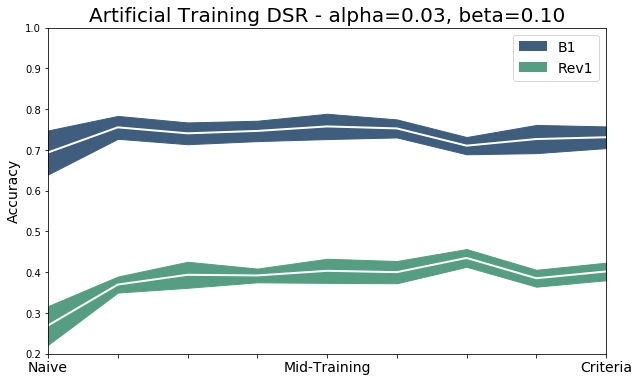

dataset completed in 5.41 seconds


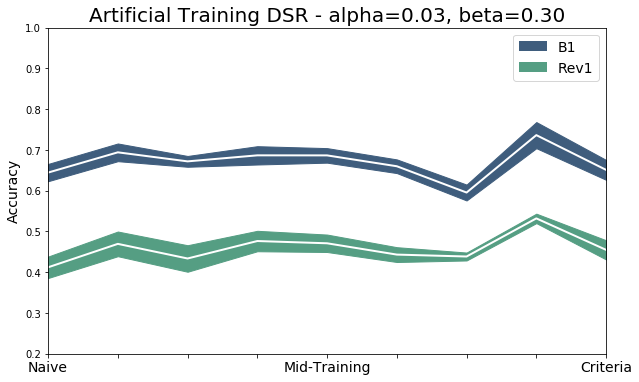

dataset completed in 5.32 seconds


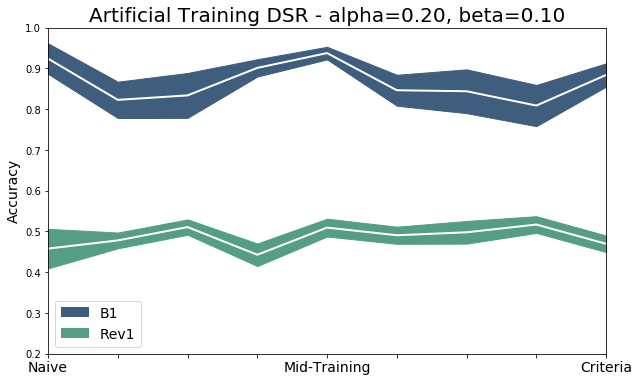

dataset completed in 5.42 seconds


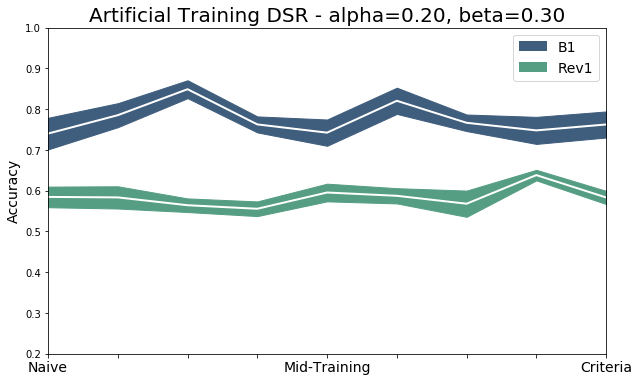

In [231]:
for alpha, beta in itertools.product([0.03, 0.2], [0.1, 0.3]):
    #generate dataset
    A_TRAINING_DSR = \
        generate_dataset(TRAINING_PSR, task = 'PSR', alpha = alpha, beta = beta)

    #obtain accuracy per block
    DSR_B1 = get_block_performances(A_TRAINING_DSR, block = 1)
    DSR_Rev1 = get_block_performances(A_TRAINING_DSR, block = 2)

    training_plot([DSR_B1, DSR_Rev1],
                  'Artificial Training DSR - alpha=%.2f, beta=%.2f' %(alpha, beta),
                  ylim = [0.2, 1],
                  savefig = 0)


## Modulating Alpha Learning Rate
What if the "learning set" can be explained by just modulating the learning rate ? What if that learning rate goes up with more experience, i.e. more training sessions ? Let's simulate this by increasing the alpha rate by 0.1 every session

In [234]:
def generate_dataset_w_alpha_increasing(TRAINING_DF, task = 'DSR', alpha = 0.03, beta = 0.1):

    rats = [label for label, data in TRAINING_DF.groupby('rat')]
    no_sessions = [len(data.groupby('training_session')) for _, data in TRAINING_DF.groupby('rat')]

    A_TRAINING_DF = []
    start = time.time()
    for ratID, no_sess in zip(rats, no_sessions):
        #instantiate rat
        rat = Rat(ratID = ratID, alpha = alpha, beta = beta)
        trials_per_session = \
            [len(sess) for label, sess in TRAINING_DF.loc[ratID].groupby('training_session')]
        for training_session_no, noTrials in zip(range(1, 1 + no_sess), trials_per_session):
            #insantiate session
            artificial_session = SessionSimulator(rat, training_session_no, task=task, noTrials = noTrials)
            #run session
            artificial_session.run_session()
            #simulate rat "resting"
            rat.rest_of_day()
            #alpha goes "up"
            rat.alpha += 0.1
            #append information
            A_TRAINING_DF.append(artificial_session.info)
    A_TRAINING_DF = pd.concat(A_TRAINING_DF, axis = 0)
    A_TRAINING_DF.sort_index(axis = 0, inplace = True)

    print 'dataset completed in %1.2f seconds' %(time.time() - start)
    return A_TRAINING_DF

dataset completed in 2.64 seconds


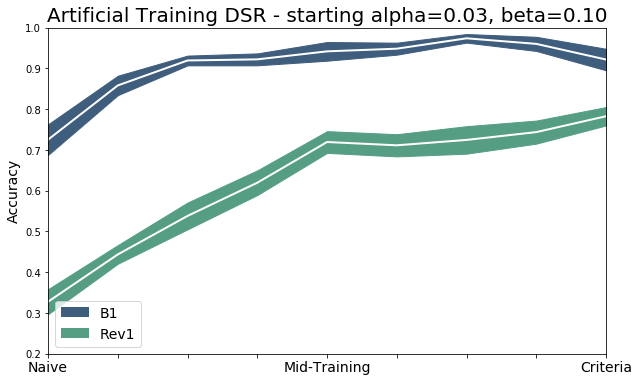

dataset completed in 2.69 seconds


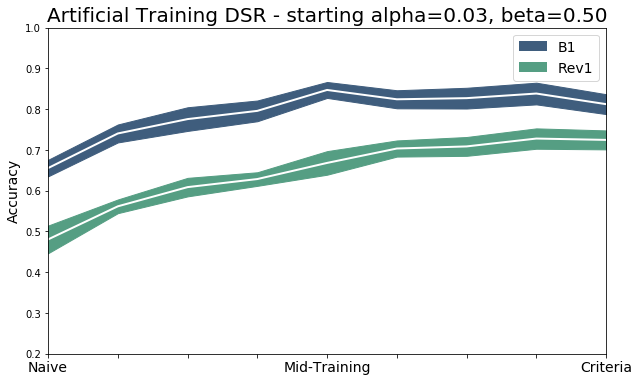

dataset completed in 2.68 seconds


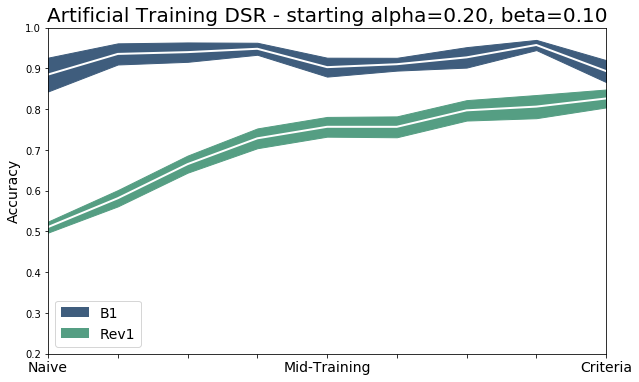

dataset completed in 2.80 seconds


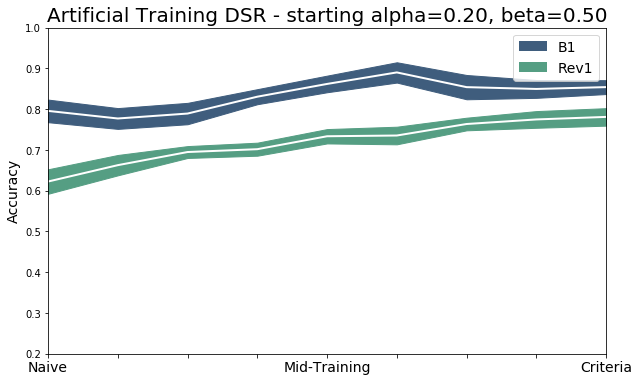

In [237]:
for alpha, beta in itertools.product([0.03, 0.2], [0.1, 0.5]):
    #generate dataset
    A_TRAINING_DSR = \
        generate_dataset_w_alpha_increasing(TRAINING_DSR, task = 'DSR', alpha = alpha, beta = beta)

    #obtain accuracy per block
    DSR_B1 = get_block_performances(A_TRAINING_DSR, block = 1)
    DSR_Rev1 = get_block_performances(A_TRAINING_DSR, block = 2)

    training_plot([DSR_B1, DSR_Rev1],
                  'Artificial Training DSR - starting alpha=%.2f, beta=%.2f' %(alpha, beta),
                  ylim = [0.2, 1],
                  savefig = 1)

dataset completed in 5.30 seconds


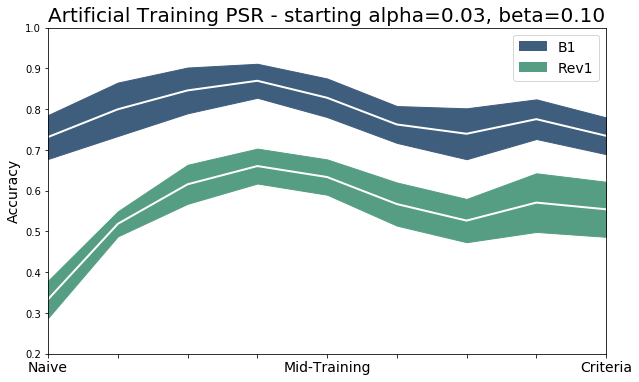

dataset completed in 5.58 seconds


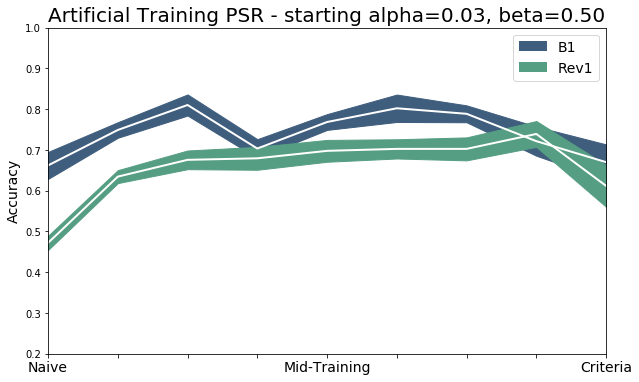

dataset completed in 5.50 seconds


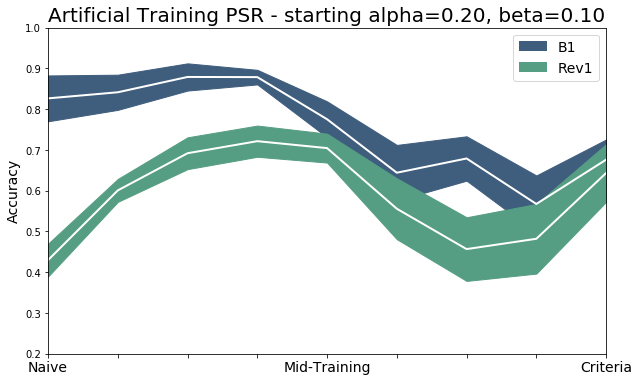

dataset completed in 5.49 seconds


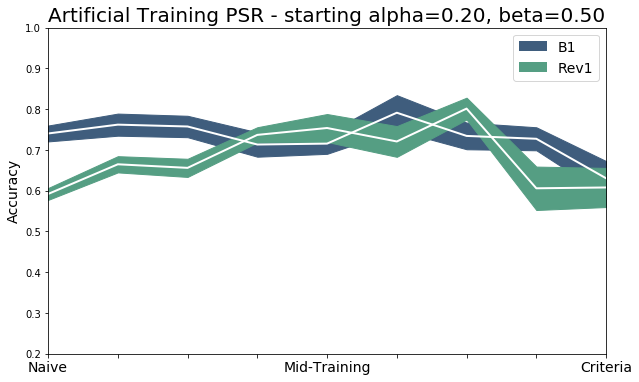

In [239]:
for alpha, beta in itertools.product([0.03, 0.2], [0.1, 0.5]):
    #generate dataset
    A_TRAINING_PSR = \
        generate_dataset_w_alpha_increasing(TRAINING_PSR, task = 'PSR', alpha = alpha, beta = beta)

    #obtain accuracy per block
    PSR_B1 = get_block_performances(A_TRAINING_PSR, block = 1)
    PSR_Rev1 = get_block_performances(A_TRAINING_PSR, block = 2)

    training_plot([PSR_B1, PSR_Rev1],
                  'Artificial Training PSR - starting alpha=%.2f, beta=%.2f' %(alpha, beta),
                  ylim = [0.2, 1],
                  savefig = 1)

## Pearce-Hall Model (1980)
Let's try a new model that is a natural evolution of R-W and may be relevant here.  The Pearce-Hall model attempted to add attention to cues as a function of the history of reward or punishment into how a cue was "attended" and thus learned from. Let's gain some intuition on how it works. Pearce-Hall model models the attention parameter for a specific cue recursively, based on the following equation:  

αn = γ|λn−1 − ∑ Vn−1| + (1 − γ)αn−1  

Let's initialize the parameter αn = 0, and see how it changes if we get give reward for 10 trials on and off for different values of γ.

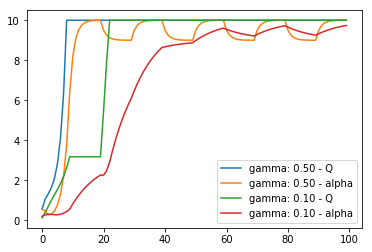

In [209]:
#V is specific to each goal. initialize at 0
new_alpha = lambda gamma, x, V, old_alpha: gamma * np.abs(x - V) + (1 - gamma) * old_alpha


curves = {}
for gamma in [0.1,0.5]:
    learning_rate = []
    Q_val = []
    alpha = 0.1
    V = (np.random.random() - 0.5)/5
    for trial in range(100):
        reward = (trial % 20) < 10
        alpha = new_alpha(gamma, reward, V, alpha)
        V += alpha * reward
        V = min(10,V)
        learning_rate.append(alpha)
        Q_val.append(V)
    curves[gamma] = {'alpha': learning_rate, 'Q' : Q_val}
    
for key, curve in curves.iteritems():
    for lab, sub_curve in curve.iteritems():
        plt.plot(sub_curve, label = 'gamma: %.2f - %s' %(key,lab))
plt.legend()
plt.show()

What is weird to me is the term in the alpha updating rule that is under the absolute value. The absolute value does not allow it to specify a direction, so that both learning rate and Q-value grow unbounded. In fact, above I had to not let it grow past 10 so we could see what is going on. Also, V will never change when there is no reward, so that non-reward might be negative ? That is not what the original paper says. For now, we will abandon this model as I am short on time and nobody cares about these old models anyways.  

My approach now is to say, every time there is a reversal, the "surprise" diminishes, so that it should be in fact inversely proportional to the learning rate. The less the surprise, the greater the learning rate. Or rather, the less surprise, the lower the increase to the learning rate.  

Let's do a quick experiment, even for the RW learning rate. Should non-reward be negative ?? Let's compare how the Q-value oscillates for 20 trials of reward and 20 trials of non-reward on and off, when reward is always coded as 1, but where non-reward is coded as either 0 or -1

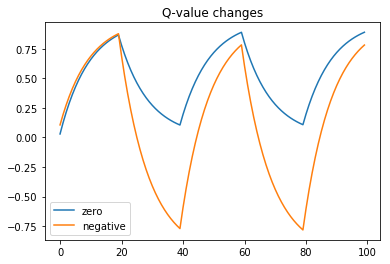

In [212]:
#first 20 trials reward, next 20 no reward, next 20 reward and so on ...
curves = {}
alpha = 0.1
for reward_type in ['zero', 'negative']:
    Q = (np.random.random() - 0.5)/5
    Q_val = []
    for trial in range(100):
        if reward_type == 'zero':
            reward = (trial % 40) < 20
        elif reward_type == 'negative':
            reward = ((trial % 40) < 20) * 2 - 1
        Q += alpha * (reward - Q)
        Q_val.append(Q)

    curves[reward_type] = Q_val
    
for key, curve in curves.iteritems():
    plt.plot(curve, label = '%s' %(key))
plt.title('Q-value changes')
plt.legend()
plt.show()

OK, I think a 0 non-reward value makes sense, otherwise the Q-value goes negative which is not really what we want. In a way it would be like doubling the alpha rate and that seems inefficient/messy. 